In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 5000
import matplotlib
import nltk
import modin
import swifter
import collections
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import logging.handlers
from prettytable import PrettyTable
from datetime import date
from tabulate import tabulate


In [3]:
# number of prototypical words to keep.
k = 20
log_to_file = False


try:
    log.info("Log is already initiated.")
except:
    if log_to_file:
        logging.basicConfig(filename=f"../data/log/log_k={k}__{date.today().strftime('%d-%m-%Y')}__.log",
                            filemode='a',
                            format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                            datefmt='%H:%M:%S',
                            level=logging.DEBUG)
        log = logging.getLogger("Bot")
        log.addHandler(logging.StreamHandler())
        log.info("###########################################################")

    else:
        log = logging.getLogger("Bot")
        log.setLevel(logging.DEBUG)
        log.addHandler(logging.StreamHandler())

In [4]:
# Read data file (2019&2020)
data = pd.read_feather('../data/feather_files/data2019clean.feather')
data = pd.concat((data,\
        pd.read_feather('../data/feather_files/data2020clean.feather')))
# Take test data out
test = data.query("tclass == 'test'").reset_index(drop=True).rename(columns={'text':'X'})[['X']]
data = data.query("tclass == 'political' or tclass=='nonpolitical'").reset_index(drop=True)
data['X'] = data.text
data['Y'] = pd.get_dummies(data.tclass).drop('nonpolitical', axis=1).values.ravel()
data = data[['X','Y']]
log.info("A data sample")
log.info(data.head(1))
log.info(f"The shape of the data is {data.shape}")
log.info('Proportions of positive (political) and negative labels:')
log.info(data.Y.value_counts() / data.shape[0]) 

A data sample
                                                                      X  Y
0      crime   democrat slogan    presidential election  anything        1
The shape of the data is (505676, 2)
Proportions of positive (political) and negative labels:
1    0.683711
0    0.316289
Name: Y, dtype: float64


In [5]:
# split to train and test
test_size = .2
train, valid = train_test_split(data,test_size=test_size, random_state=100,shuffle=True, stratify=data.Y)
#data=None
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
log.info(f"Taking {round(.2*100,2)}% test subset. The resulting train shape is {train.shape} and test shape is {valid.shape}" )
train.to_feather(f'../data/feather_files/splits/train_{k}.feather')
valid.to_feather(f'../data/feather_files/splits/valid_{k}.feather')
test.to_feather(f'../data/feather_files/splits/test.feather')

Taking 20.0% test subset. The resulting train shape is (404540, 2) and test shape is (101136, 2)


In [6]:

if 0:
    #proto = pd.read_feather('../data/feather_files/proto_8.feather')
    worddict = pd.read_feather('../data/feather_files/worddict_800.feather')
    wp_proto = pd.read_feather('../data/feather_files/wp_proto_800.feather')
    wp_in_u = pd.read_feather('../data/feather_files/wp_in_u_800.feather')
    #proto2 = pd.read_feather('../data/feather_files/proto2.feather')

# Step 2

In [7]:
# get text columns for training datasets
log.info("dividng data into classes")
pol = train.query("Y == 1").X
nonpol = train.query("Y == 0").X
pol_valid = valid.query("Y==1").X
nonpol_valid = valid.query("Y==0").X
# Get a long string of all text for each of the categories to analyse
log.info("Joining the series of text into one string per category")
long_str_p = ' '.join(pol)
long_str_np = ' '.join(nonpol)
long_str_t = ' '.join(test.X)
long_str_p_v = ' '.join(pol_valid)
long_str_np_v = ' '.join(nonpol_valid)
# Transform that string into a list of strings
log.info("Dividing those long strings into lists of words")
tokens_p = long_str_p.split()
tokens_np = long_str_np.split()
tokens_t = long_str_t.split()
tokens_p_v = long_str_p_v.split()
tokens_np_v = long_str_np_v.split()

dividng data into classes
Joining the series of text into one string per category
Dividing those long strings into lists of words


Creating wordclouds of each class (pol, nonpol, Canada) and saving the resulting images to disk
word cloud 1/3
Political wordcloud


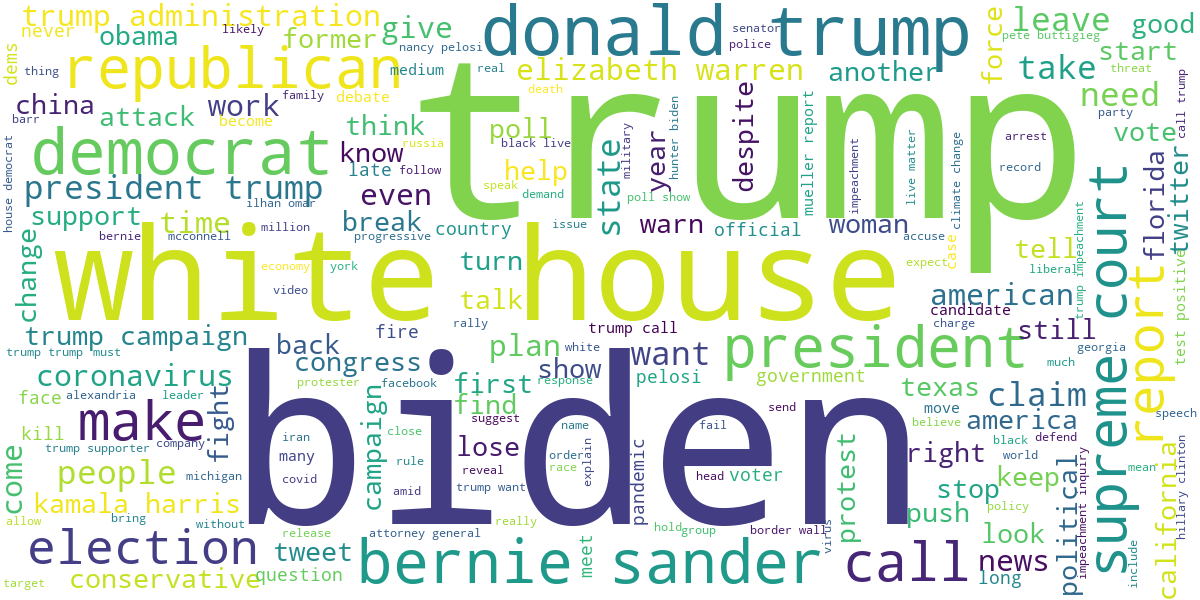

word cloud 2/3
non- Political wordcloud


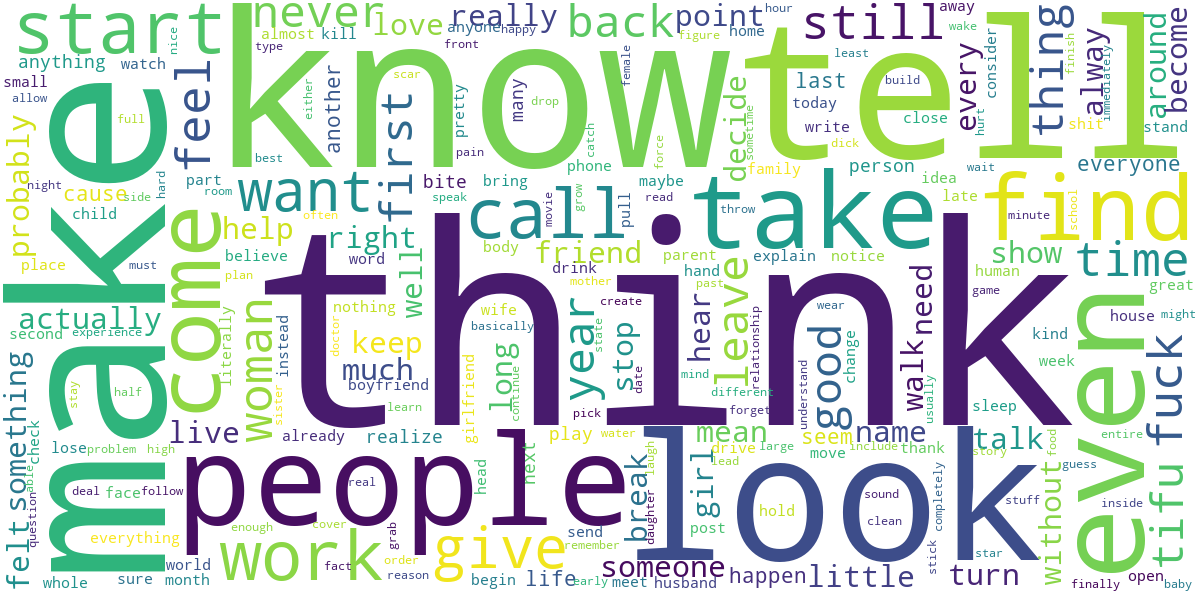

word cloud 3/3
R/Canada (test)


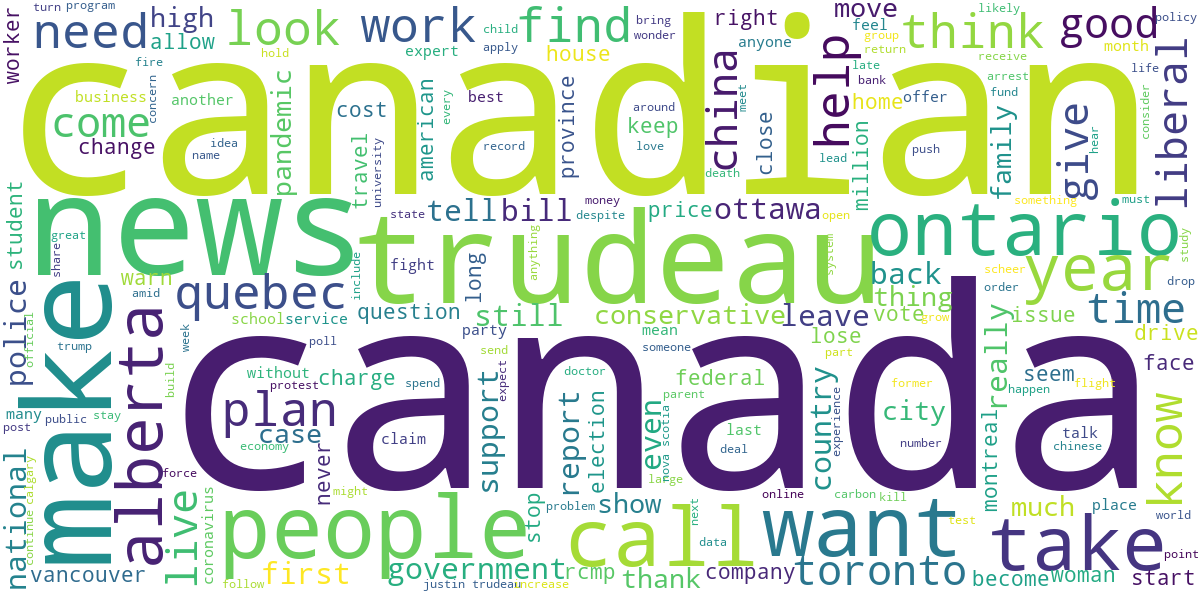

In [8]:
# Printing a WordCloud for each of them. [saving to file]
log.info("Creating wordclouds of each class (pol, nonpol, Canada) and saving the resulting images to disk")
wordcloud = WordCloud(background_color="white", max_words=5000,\
                  contour_width=6, contour_color='steelblue', scale=3)
# Generate the first
log.info("word cloud 1/3")
log.info("Political wordcloud")
wordcloud.generate(long_str_p+long_str_p_v)
wordcloud.to_image()
wordcloud.to_file(f'../data/images/political_{k}.png')

# Generate the second wordcloud [saving to file]
log.info("word cloud 2/3")
log.info("non- Political wordcloud")
wordcloud.generate(long_str_np+long_str_np_v)
wordcloud.to_image()
wordcloud.to_file(f'../data/images/nonpolitical_{k}.png')

# Generate the third wordcloud [saving to file]
log.info("word cloud 3/3")
log.info("R/Canada (test)")
wordcloud.generate(long_str_t)
wordcloud.to_image()
wordcloud.to_file(f'../data/images/CA_test_{k}.png')

In [9]:
# Counting the occurences of each of the words. Output: list (word, #occurences)
log.info("Couting the occurences of each word per class")
log.info(f"Total umber of words (training+validation) is:")
log.info(f"Political: {len(tokens_p)+len(tokens_p_v)}, nonpolitical: {len(tokens_np)+len(tokens_np_v)}, and test: {len(tokens_t)}")
counter_p = collections.Counter(tokens_p)
counter_np = collections.Counter(tokens_np)
counter_t = collections.Counter(tokens_t)
log.info(f"Number of distinct training words for each class is {len(counter_p)}, {len(counter_np)}, and {len(counter_t)}")

log.info("Visualizing the top 15 common words in each category [latex code below]")

table = PrettyTable()

table.title = 'Most common 15 words in each category '
table.add_column('Political', np.transpose(collections.Counter(tokens_p+tokens_p_v).most_common(15))[0])
table.add_column('Non-Political', np.transpose(collections.Counter(tokens_np+tokens_np_v).most_common(15))[0])
table.add_column('Canada', np.transpose(counter_t.most_common(15))[0])
log.info(table)
log.info(table.get_latex_string())
del tokens_p, tokens_np, tokens_t

Couting the occurences of each word per class
Total umber of words (training+validation) is:
Political: 2527675, nonpolitical: 3903092, and test: 332602
Number of distinct training words for each class is 25052, 48967, and 15191
Visualizing the top 15 common words in each category [latex code below]
+------------------------------------------+
|  Most common 15 words in each category   |
+-------------+---------------+------------+
|  Political  | Non-Political |   Canada   |
+-------------+---------------+------------+
|    trump    |      like     |   canada   |
|    biden    |      make     |  canadian  |
|    house    |      know     |  trudeau   |
| coronavirus |     think     |    news    |
|     call    |      tell     |   would    |
|   democrat  |     would     |    make    |
|  president  |      want     |    like    |
|    white    |      take     |    want    |
|   election  |      time     |   people   |
|     vote    |     people    | government |
|  republican |      fee

Extracting first feature.
The tabl worddict would contain for each word: #occurences in each of the categories and the scores
Later, I will keep only the top 200 words in each category (only training categories are considered)

In [10]:
%%time
log.info("Creating a table of the number of occurence of each word in each of the two classes. Saved as worddict")
# Make a table of word - #occurances in class 1 - #occurances in class 2 [saving to file]
worddict = pd.DataFrame({'word':counter_p.keys(),'pol_occ': counter_p.values()})
worddict['nonpol_occ'] = worddict.word.swifter.apply(lambda x: counter_np.get(x,0))
#----------------------------- class 2
temp = pd.DataFrame({'word':counter_np.keys(), 'nonpol_occ': counter_np.values()})
temp['pol_occ'] = temp.word.swifter.apply(lambda x: counter_p.get(x,0))
#Merge
worddict = pd.concat((worddict,temp)).drop_duplicates('word').sort_values(by='pol_occ',ascending=False)
#------------------------------------------------------------------
#log
log.info(f"Number of distinct words is {len(worddict)}")
n=50
log.info(f"Droping word occuring less than {n} times")
# Drop words occuring less than n times
worddict = worddict.query('pol_occ >= @n or nonpol_occ >= @n').reset_index(drop=True)
log.info(f" number of words occuring at least {n} times is {len(worddict)} words")

# Computer score a
log.info("Computing proto score. Equation 1. Objective, choose top k words")
worddict['ssum'] = worddict.pol_occ + worddict.nonpol_occ
worddict['sc_p'] = worddict.pol_occ / worddict.ssum
worddict['sc_np'] = worddict.nonpol_occ / worddict.ssum
# Remove non-words (ie. names)
log.info("Removing names and other non-recognizable words. Unfortunately, some names would be detected since they hold a second meaning")
worddict = worddict[worddict.word.isin(nltk.corpus.words.words('en'))]
# Keep top k words in each class - 
#k = 400
log.info(f"keeping top {k} words in each class")
temp = worddict.sort_values(by='sc_p', ascending=False)[0:k]
temp['Y'] = 1
worddict = worddict.sort_values(by='sc_np', ascending=False)[0:k]
worddict['Y'] = 0
worddict = pd.concat((temp, worddict))
worddict = worddict.drop_duplicates('word')\
.sort_values(by='sc_p', ascending=False).reset_index(drop=True)
log.info(f"Number of words after keeping top {k} words is {len(worddict)}")
# save to disk
worddict.to_feather(f'../data/feather_files/worddict_{k}.feather')
del temp, counter_p, counter_np, counter_t

Creating a table of the number of occurence of each word in each of the two classes. Saved as worddict


Pandas Apply:   0%|          | 0/25052 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/48967 [00:00<?, ?it/s]

Number of distinct words is 56255
Droping word occuring less than 50 times
 number of words occuring at least 50 times is 6385 words
Computing proto score. Equation 1. Objective, choose top k words
Removing names and other non-recognizable words. Unfortunately, some names would be detected since they hold a second meaning
keeping top 20 words in each class
Number of words after keeping top 20 words is 40


Wall time: 610 ms


Creating wordcloud of each of the k=20 words and saving them inside /data/images/
top political wordcloud


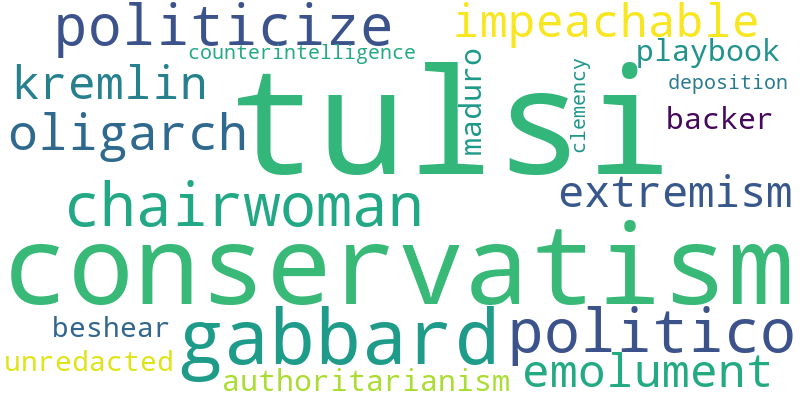

top non-political wordcloud


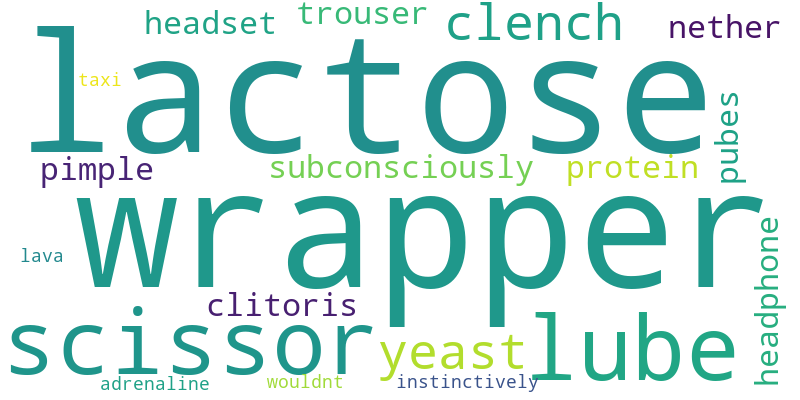

In [11]:
# Printing a WordCloud for each of them. [saving to file]
log.info(f"Creating wordcloud of each of the k={k} words and saving them inside /data/images/")
wordcloud = WordCloud(background_color="white", max_words=5000,\
                  contour_width=6, contour_color='steelblue', scale=2)
# Generate the first
log.info("top political wordcloud")
l_p=' '.join( worddict.query("Y == 1").word)
wordcloud.generate(l_p)
wordcloud.to_image()
wordcloud.to_file(f'../data/images/political_top_{k}.png')
# Generate the second
log.info("top non-political wordcloud")
l_np=' '.join(worddict.query("Y == 0").word)
wordcloud.generate(l_np)
wordcloud.to_image()
wordcloud.to_file(f'../data/images/nonpolitical_top_{k}.png')
del l_np, l_p

In [12]:
%%time

# wp_in_u includes the frequency of the selected words in each of the posts
# the shape is list of lists. posts x words
#.allow_dask_on_strings(enable=True)\
#.swifter.allow_dask_on_strings(enable=True).apply
log.info("Couting the occurence of the chosen words inside each of the posts. The resulting dataframe is of shape (number of posts)x(2k).")
wp_in_u=train.X.swifter.apply(lambda d:( [d.count(wp) for wp in worddict.word]))
wp_in_u = pd.DataFrame(wp_in_u)
wp_in_u.to_feather(f'../data/feather_files/wp_in_u_{k}.feather')
log.info(f"saved as wp_in_u_{k} with the dimension of {wp_in_u.shape}")

Couting the occurence of the chosen words inside each of the posts. The resulting dataframe is of shape (number of posts)x(2k).


Pandas Apply:   0%|          | 0/404540 [00:00<?, ?it/s]

saved as wp_in_u_20 with the dimension of (404540, 1)


Wall time: 10.7 s


--------------------
#### Proto

In [44]:
%%time
#Transform wp_in_u into a dataframe.
# needs to loop on each post to transform individual lists.
log.info(f"Transforming the previous variable into a dataframe. saved as wp_proto_{k}")
wp_proto = wp_in_u.swifter.apply(lambda d: pd.Series(d[0]), axis=1)
wp_proto.columns = worddict.word
wp_proto.index = train.index
#------------------------------------------------------------------------------------------------------------
# Detecting and fixing outliers.
# all occurances of more than 30 will be set to 30.
#outliers = pd.DataFrame(columns=['Word','Occurences>50'])
log.info("Finding outliers and printing them.")
log.info("Words appearing more than 30 times in the same post are considered as outliers.")
log.info("No action is being taken atm but we can consider resetting them to 30")
# def find_outliers(tt):
#         occ = ','.join([str(x) for x in np.sort(tt[tt>50])])
#         if occ == '':
#             return
#         #wp_proto[tt.name][tt.index] = 30 # For now untill I implement the score
#         return np.transpose([tt.name, occ])


# try:
    
#     outliers = wp_proto.swifter.apply(find_outliers)
#     outliers = outliers.values[~pd.isna(outliers.values)]
#     outliers = np.transpose([ t.tolist() for t in outliers.tolist()])

#     table = PrettyTable()
#     table.title = 'Words occuring more than 30 times in a single post'
#     table.add_column('word', outliers[0])
#     table.add_column('high occurences', outliers[1])
#     log.info(table)        
# except:
#     pass
    
wp_proto.to_feather(f'../data/feather_files/wp_proto_{k}.feather')


# sum of all words in each post
log.info("Computing the sum of words in each post")
sum_proto = train.X.swifter.apply(lambda d: len(d.split()))
# proto. Final feature (post x wp_word)
log.info("Creating the first set of features, equation 2. (#occurence of wp in u)/(#words in u). A table of (#posts)x(2k)")
proto = wp_proto.divide(sum_proto,axis=0)
proto.to_feather(f'../data/feather_files/proto_{k}.feather')
log.info(f"saved as proto_{k}")

#del train, wp_proto, outliers, wp_in_u

Transforming the previous variable into a dataframe. saved as wp_proto_20


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Finding outliers and printing them.
Words appearing more than 30 times in the same post are considered as outliers.
No action is being taken atm but we can consider resetting them to 30
Computing the sum of words in each post


Pandas Apply:   0%|          | 0/404540 [00:00<?, ?it/s]

Creating the first set of features, equation 2. (#occurence of wp in u)/(#words in u). A table of (#posts)x(2k)
saved as proto_20


Wall time: 42.6 s


In [45]:
%%time
# Second score. For each class, a post gets a score
log.info("The next feature is a score per (post,class)")
proto_train = pd.DataFrame()
# The numerator
proto_train['sc_p'] = proto[worddict.query("Y == 1").word].sum(axis=1)
proto_train['sc_np'] = proto[worddict.query("Y == 0").word].sum(axis=1)
# Divide by the denomerator (same as the previous score)
proto_train = proto_train.divide(sum_proto,axis=0)
log.info('Computing training set predictions (1 if matches, 0 if not, nonres_flag = -1 if both probabilities are 0')
proto_train['Y'] = train.Y
proto_train['Y_pred'] = (proto_train.sc_p > proto_train.sc_np).astype(int)
#proto_train['accuracy'] = (proto_train.Y == proto_train.Y_pred).astype(int)
proto_train['nonresp_flag'] = 0
proto_train.loc[proto_train.eval('sc_p == sc_np == 0'),'nonresp_flag'] = 1
#proto_train.query('sc_p == sc_np == 0')['nonresp_flag'] = 1
log.info('saving to disk')
# save to disk
proto_train.to_feather(f'../data/feather_files/proto_train_{k}.feather')
log.info(f"saved as proto_train_{k}")
log.info(proto_train.sample(3))
#del proto_train, worddict, sum_proto

The next feature is a score per (post,class)
Computing training set predictions (1 if matches, 0 if not, nonres_flag = -1 if both probabilities are 0
saving to disk
saved as proto_train_20
        sc_p  sc_np  Y  Y_pred  nonresp_flag
24500    0.0    0.0  1       0             1
362634   0.0    0.0  0       0             1
175206   0.0    0.0  1       0             1


Wall time: 223 ms


In [48]:
%%time
log.info("Computing the probabilities of classes given proto words")
log.info("The pclass is an assignment to the class of higher probability")
# probabilities of class given a proto word.
# the pclass is an  assignment to the class of higher probability
# Rows are words
protom = pd.DataFrame()
    
protom['sc_p'] = proto.swifter.apply(lambda d: d.mul(proto_train.sc_p).sum())
protom['sc_np'] = proto.swifter.apply(lambda d: d.mul(proto_train.sc_np).sum())
protom['Y'] = protom.swifter.apply(lambda d: d.sc_p > d.sc_np,axis=1)
protom['word'] = proto.columns
log.info("dataframe was created successfully. Saving to disk...")
log.info(protom.sample(3))
protom.reset_index(drop=True).to_feather(f'../data/feather_files/proto_W_C_{k}.feather')
log.info('saved to disk')
#del proto

Computing the probabilities of classes given proto words
The pclass is an assignment to the class of higher probability


Pandas Apply:   0%|          | 0/40 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/40 [00:00<?, ?it/s]

dataframe was created successfully. Saving to disk...
              sc_p     sc_np      Y      word
word                                         
pubes     0.000000  1.557624  False     pubes
clitoris  0.000000  0.223544  False  clitoris
backer    0.916661  0.000000   True    backer
saved to disk


Wall time: 6.21 s


In [22]:
%%time
log.info("Computing validation set predictions")
proto_valid = pd.DataFrame()
log.info("The class prob of a post is the sum of class|word probabilties for all proto word in class and in post")

temp = protom[['sc_p','sc_np']]
proto_valid[['sc_p','sc_np']] = valid.X.swifter.apply(lambda d :  temp[protom.word.isin(d.split())].sum())[['sc_p','sc_np']]


proto_valid['Y'] = valid.Y # 1 for p and 0 for np

proto_valid['Y_pred'] = (proto_valid.sc_p > proto_valid.sc_np).astype(int)  # 1 for p and 0 for np
#proto_valid['accuracy'] = (proto_valid.Y == proto_valid.Y_pred).astype(int)
proto_valid['nonresp_flag'] = 0
proto_valid.loc[proto_valid.eval('sc_p == sc_np == 0'),'nonresp_flag'] = 1
log.info('saving to disk')
# save to disk
proto_train.to_feather(f'../data/feather_files/proto_valid_{k}.feather')
log.info(f"saved as proto_valid_{k}")
log.info(proto_valid.sample(3))


Computing validation set predictions
The class prob of a post is the sum of class|word probabilties for all proto word in class and in post


Pandas Apply:   0%|          | 0/101136 [00:00<?, ?it/s]

saving to disk
saved as proto_valid_20
       sc_p  sc_np  Y  Y_pred  nonresp_flag
67041   0.0    0.0  1       0             1
5263    0.0    0.0  1       0             1
85807   0.0    0.0  0       0             1


Wall time: 1min 36s


In [51]:
from sklearn.metrics import f1_score, accuracy_score

def scorer(y_true, y_pred, flag):
    scr = pd.Series(dtype=np.float32)
    scr["nonresponse"] = flag.value_counts().loc[1] / len(flag)
    scr["f1_score"] = f1_score(y_true, y_pred)
    scr["f1_score_a"] = f1_score(y_true[flag==0], y_pred[flag==0])
    scr["Accuracy"] = accuracy_score(y_true, y_pred)
    scr["Accuracy_a"] = accuracy_score(y_true[flag==0], y_pred[flag==0])
    return scr

scores = pd.DataFrame()


scores[f'Valid_{k}'] = scorer(proto_valid.Y, proto_valid.Y_pred, proto_valid.nonresp_flag)
scores[f'Train_{k}'] = scorer(proto_train.Y, proto_train.Y_pred, proto_train.nonresp_flag)

scores.reset_index().to_feather(f'../data/feather_files/scores_k={k}.feather')
#-----------------------------------------------------------------------------------
print(tabulate(scores, headers='keys', tablefmt='psql'))
log.info(tabulate(scores, headers='keys', tablefmt='latex_raw'))

\begin{tabular}{lrr}
\hline
             &   Valid_20 &   Train_20 \\
\hline
 nonresponse &  0.989934  &   0.989116 \\
 f1_score    &  0.0186233 &   0.019682 \\
 f1_score_a  &  0.989346  &   0.997641 \\
 Accuracy    &  0.322645  &   0.323076 \\
 Accuracy_a  &  0.986248  &   0.997047 \\
\hline
\end{tabular}


+-------------+------------+------------+
|             |   Valid_20 |   Train_20 |
|-------------+------------+------------|
| nonresponse |  0.989934  |   0.989116 |
| f1_score    |  0.0186233 |   0.019682 |
| f1_score_a  |  0.989346  |   0.997641 |
| Accuracy    |  0.322645  |   0.323076 |
| Accuracy_a  |  0.986248  |   0.997047 |
+-------------+------------+------------+
